In [10]:
import sys
sys.path.append('../')
import pandas as pd
import seaborn as sns; sns.set(style='whitegrid', context='paper', 
                               rc={'font.size': 7, 
                                   'axes.titlesize': 9,
                                   'axes.labelsize': 8,
                                   'xtick.labelsize': 7,
                                   'ytick.labelsize': 7, 
                                   'figure.constrained_layout.use': True,
                                   'figure.constrained_layout.w_pad': 0.1,
                                   'figure.constrained_layout.h_pad': 0.1,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}

---
# Figure 1 - Dimensionality vs. encoding performance

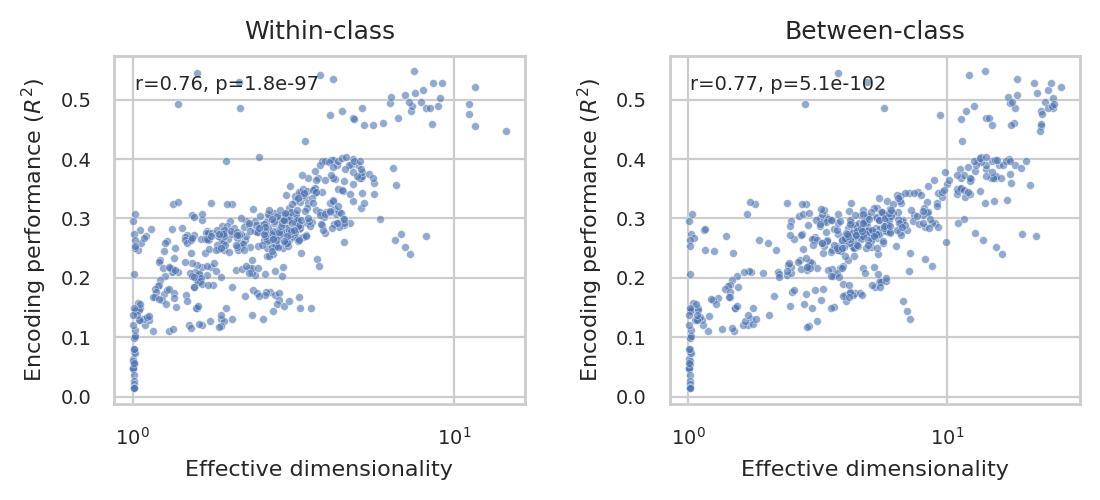

In [12]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=['architecture', 'task', 'kind', 'source', 'layer'])
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig = plt.figure(figsize=(5.5, 2.5))
gs = fig.add_gridspec(1, 2)
axs = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])

sns.scatterplot(data=data, x='between-concept dimensionality', y='score', alpha=0.6, s=8, ax=axs[0])
axs[0].set(title='Within-class', xlabel='Effective dimensionality', ylabel=r'Encoding performance ($R^2$)', xscale='log')
annotate_corr(data, x='between-concept dimensionality', y='score', ax=axs[0])

sns.scatterplot(data=data, x='within-concept dimensionality (mean)', y='score', alpha=0.6, s=8, ax=axs[1])
axs[1].set(title='Between-class', xlabel='Effective dimensionality', ylabel=r'Encoding performance ($R^2$)', xscale='log')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', ax=axs[1])

plt.savefig('saved/results_01_ED.png', dpi=300)
plt.show()